In [1]:
from config import DB_PATH
from tesis import apply_mpl_style
apply_mpl_style()

In [2]:
# ─────────────────────────────  PREPARACIÓN  ──────────────────────────────
import os
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from tesis.graficos_utils import (
    add_hitos, add_cycle_means_multi,
    add_year_value_annotations, add_period_growth_annotations_multi
)

In [3]:
# 0. Ciclos y carpetas
periods = {
    "Expansión 92-99": slice(1992, 1999),
    "Crisis 00-05":    slice(2000, 2005),
    "Expansión 06-13": slice(2006, 2013),
    "Recesión 14-23":  slice(2014, 2023),
}
output_dir = "../../../../assets/tesis/serie_completa/finanzas"
os.makedirs(output_dir, exist_ok=True)

In [4]:
# 1. Datos ────────────────────────────────────────────────────────────────
with sqlite3.connect(DB_PATH, uri=True) as conn:
    df = (
        pd.read_sql("SELECT * FROM consolidado_spnf", conn)
        .set_index("año")
        .sort_index()
    )

In [17]:
# Variables a graficar
cols = ["ingresos_totales", "egresos_totales", "sup_o_def_global"]
abbr = {
    "ingresos_totales": "Ing",
    "egresos_totales":  "Egr",
    "sup_o_def_global": "Def",
}
colors = {
    "ingresos_totales": "#1f77b4",
    "egresos_totales":  "#d62728",
    "sup_o_def_global": "#2ca02c",
}

cycle_stats = {
    name: df.loc[slc, cols].mean().to_dict()
    for name, slc in periods.items()
}

hitos_v = {2000: "Crisis", 2006: "Expansión", 2014: "Recesión"}
hitos_offset = {yr: 0.85 for yr in hitos_v}

anot_years = [1992, 2000, 2006, 2014, 2023]
annotation_offsets = {
    "ingresos_totales": {yr: (0, 1500) for yr in anot_years},
    "egresos_totales":  {yr: (0, -1500) for yr in anot_years},
    "sup_o_def_global": {yr: (0,  500) for yr in anot_years},
}

growth_periods = [(1992,2000),(2000,2006),(2006,2014),(2014,2023)]
period_growth_offsets = {
    "1992-2000": (1995,0.70),
    "2000-2006": (2001,0.70),
    "2006-2014": (2008,0.70),
    "2014-2023": (2016,0.3),
}
cycle_text_offsets = {
    "Expansión 92-99": (1995,0.95),
    "Crisis 00-05":    (2001,0.95),
    "Expansión 06-13": (2008,0.95),
    "Recesión 14-23":  (2016,0.50),
}

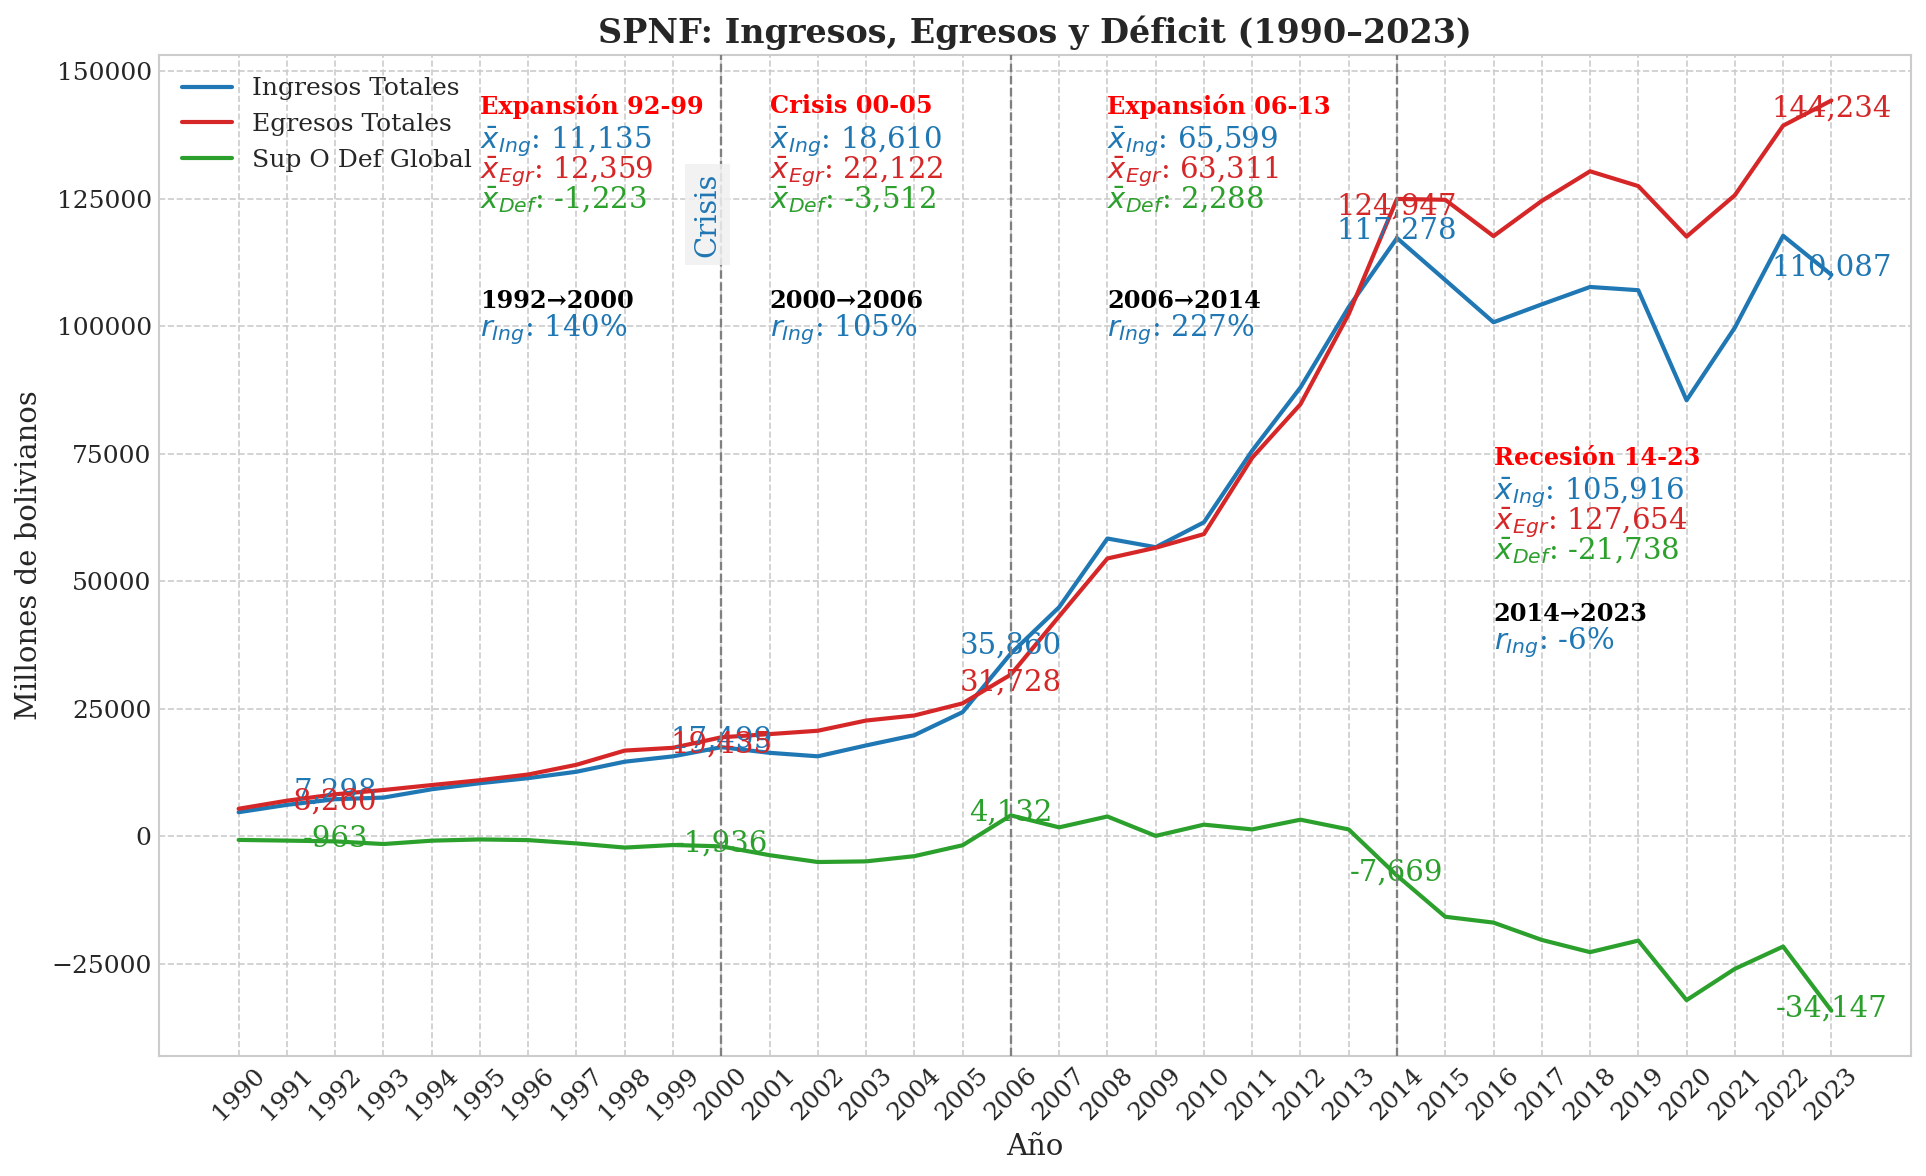

In [18]:
fig, ax = plt.subplots(figsize=(13,8))
for col in cols:
    ax.plot(df.index, df[col], label=col.replace('_',' ').title(), color=colors[col])

add_hitos(ax, df.index, hitos_v, hitos_offset)
add_cycle_means_multi(
    ax, cycle_stats, cycle_text_offsets,
    abbr, colors,
    line_spacing=df[cols[0]].max()*0.05
)
add_year_value_annotations(
    ax, df, anot_years, cols,
    annotation_offsets, colors, arrow_lw=0.6
)
add_period_growth_annotations_multi(
    ax, df, growth_periods, ["ingresos_totales"],
    period_growth_offsets, colors, {"ingresos_totales":"Ing"}
)

ax.set_title(f"SPNF: Ingresos, Egresos y Déficit ({df.index[0]}–{df.index[-1]})", fontweight="bold")
ax.set_xlabel("Año")
ax.set_ylabel("Millones de bolivianos")
ax.set_xticks(df.index[::max(1, len(df)//31)])
ax.tick_params(axis="x", rotation=45)
ax.legend(loc="upper left")

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "consolidado_spnf.png"), dpi=300)
plt.show()